# Statistical Analysis of Packet Errors

In the PRAC algorithm ["PRAC: Exploiting Partial Packets without Cross-layer or Feedback Information", Angelopoulos, Chandrakasan, Médard] the possibility of using packets that are known to contain falsified information is proposed.

To know which errors have to be dealt with in a wireless transmission scenario, it has to be examined
1. how many errors occur in broken packets
2. how many packets are broken in total
3. where errors can be found

depending on typical data rates of IEEE 802.11 standards.

In this notebook, additional focus is placed on 
* the impact of different 802.11 implementations 
* the possible gain the proposed algorithm can have.
* perfomance of the used analysis algorithms

## 0. Input data
Packets of 10000 binary values of '0' were sent from a router to a Raspberry Pi in an adjacent room over WiFi. Those packets discarded by the network adapter because of an faulty CRC were saved and put into the dataframe.
As only '0's were sent, any '1' represents an error.

Additionally, the total number of sent packets, including the successful transmissions, is loaded.

<font color='red',size=9>
Note
</font>
<font color='red'>
General note: I would suggest displaying the grid on all figures
</font>

In [4]:
%%time
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 5)

total_sent = pd.read_csv('total_sent.csv', sep="\t", index_col="Data_rate")

dataframe = pd.read_msgpack('across_rooms_automated.msg')
dataframe[-3:]

CPU times: user 460 ms, sys: 390 ms, total: 850 ms
Wall time: 898 ms


Only those packets
* sent by the access point and 
* of right length 

are assumed to be useful.

As the total number of packets with successful transmissions included only contains packets sent from the access point, those sent from the Raspberry Pi can be excluded from the beginning.

In [5]:
dataframe = dataframe[dataframe['AP_pkt']]

On the other hand, the total number of transmissions will include the those packets with wrong lengths.
Plotted below is the percentage of those:

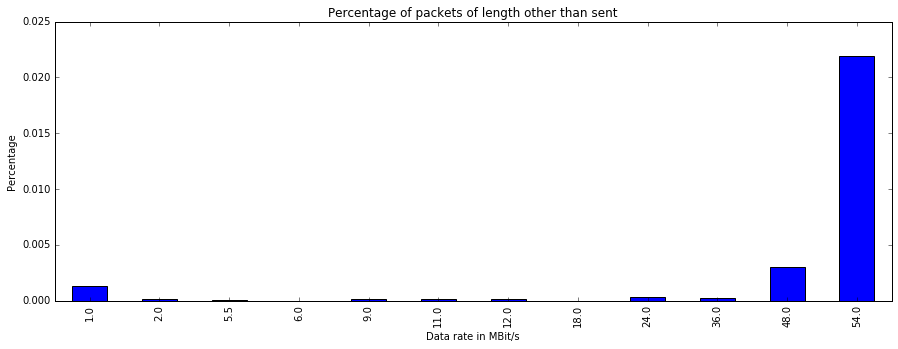

In [6]:
numbers_wrong_length = dataframe[dataframe['Right_Length'] == False].groupby('Data_rate').aggregate(sum)['Broken']
percentage_wrong_length = numbers_wrong_length.div(total_sent['Pkts_captured'])
ax = percentage_wrong_length.plot(kind='bar')
data_rate_label = "Data rate in MBit/s"
ax.set_xlabel(data_rate_label)
ax.set_ylabel("Percentage")
_ = ax.set_title("Percentage of packets of length other than sent")

As the number of broken packets with lengths other than 10000 is little with every data rate (except 54 MBit/s), the phrasing "broken packet" is almost equivalent to "potentially useful broken packets" and will be used as a synonym.

In [7]:
right_length = dataframe[dataframe['Right_Length']]

As the test data contains only packets with a failed CRC,

In [8]:
dataframe['Broken'].all()

True

the number of broken packets per data rate can be determined via the 'Broken' column, where 'True' values have been added up.

<font color='red',size=9>
Note
</font>
<font color='red'>
The following graph is counting the number of broken packets, not number of bits. Fix y axis
</font>

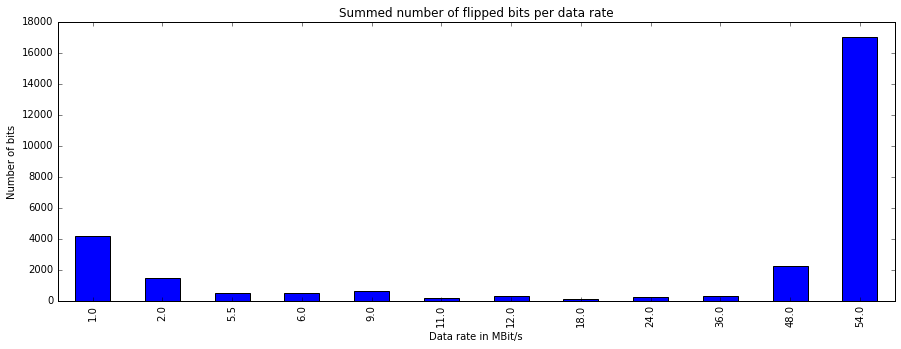

In [10]:
groupedbydatarate = right_length.groupby('Data_rate').aggregate(sum)
ax = groupedbydatarate['Broken'].plot(kind='bar')
ax.set_xlabel(data_rate_label)
ax.set_ylabel('Number of bits')
_ = ax.set_title('Summed number of flipped bits per data rate')

## 1. Flipped bits per data rate
At first, the total amount of flipped bits have to be analysed. In the grouped dataframe, the column "Flipped_bits" already contains these numbers. 

These have to be divided by the amount of bits sent per data rate. 

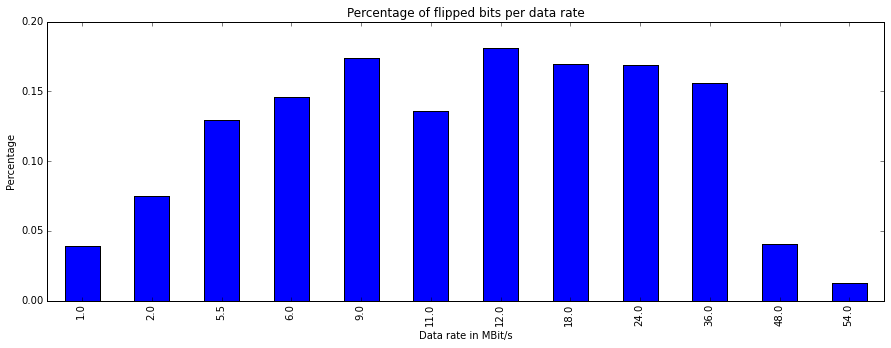

In [14]:
percentage_flipped = (groupedbydatarate['Flipped_bits']/groupedbydatarate['Broken']).div(10000)
ax = percentage_flipped.plot(kind='bar')
ax.set_xlabel(data_rate_label)
ax.set_ylabel("Percentage")
_ = ax.set_title("Percentage of flipped bits per data rate")

While lower and higher data rates have less errors per packet, the intermediate ones (5.5 - 36MBit/s) have 12.9% to 18.1% bits flipped.

The plot also shows some the presence of statistical outliers. Especially the data rate of 11MBit/s

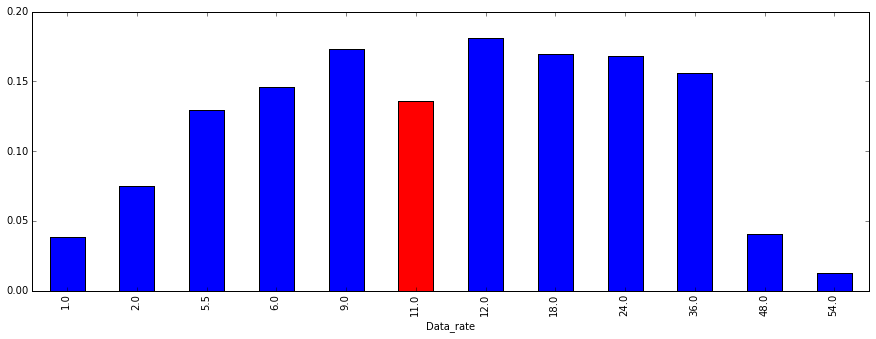

In [15]:
percentage_flipped.plot(kind='bar', color='bbbbbrbbbbbbb')
ax.set_xlabel(data_rate_label)
ax.set_ylabel("Percentage")
_ = ax.set_title("Percentage of flipped bits per data rate")

raises the question if every data rate has the same underlying technological parameters.

### Data rates and IEEE 802.11 standards
#### Identification
The data rates
 * 5.5 MBits/s and
 * 11 MBits/s
 
are only supported by [IEEE 802.11b][1]

Furthermore, 
* 1 MBit/s and
* 2 MBit/s

will be sent with 802.11b, as the only other standard using them - [IEEE 802.11-1997][2] - is rarely implemented or used today (and b is its successor since 1999). 

In the 2.4GHz band, the other rates 6, 9, 12, 18, 24, 36, 48 and 54 MBit/s are only available in IEEE 802.11g.


#### Differences

The [main differences][3] between the two standards are

* the use of channel coding:
 - b does not use any FEC
 - g uses a convolutional code
* radio technology:
 - b uses Discrete Sequence Spectrum Spread
 - g uses OFDM
 
The plot below highlights the data rates belonging to the two standards:

[1]:https://en.wikipedia.org/wiki/IEEE_802.11#Protocol "Table of IEEE 802.11 standards"
[2]:https://en.wikipedia.org/wiki/IEEE_802.11_%28legacy_mode%29 "Wikipedia article on IEEE 802.11-1997"
[3]:http://www.tutorialspoint.com/wi-fi/wifi_ieee_standards.htm "Short summary of IEEE 802.11b/g standards"

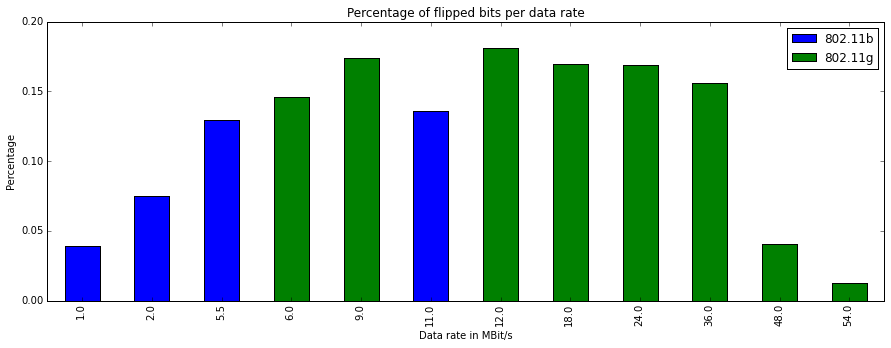

In [16]:
percentage_flipped_b = percentage_flipped[[1.0, 2.0, 5.5, 11.0]]
percentage_flipped_b.name = "802.11b"
percentage_flipped_g = percentage_flipped.drop(percentage_flipped_b.index)
percentage_flipped_g.name = "802.11g"
ax = pd.concat([percentage_flipped_b, percentage_flipped_g], axis=1).plot(kind='bar', stacked=True)
ax.set_xlabel(data_rate_label)
ax.set_ylabel("Percentage")
_ = ax.set_title("Percentage of flipped bits per data rate")

Except for 11 MBit/s, the other data rates belong to IEEE 802.11b do not stand out in terms of the overall shape of the diagram.

## 2. Broken packets per data rate

Looking at the number of broken packets related to the total number of packets sent per data rate, we see the following:

<font color='red',size=9>
Note
</font>
<font color='red'>
In the following graph, the y axis needs to be multiplied by 100 so it shows percentage :)
</font>

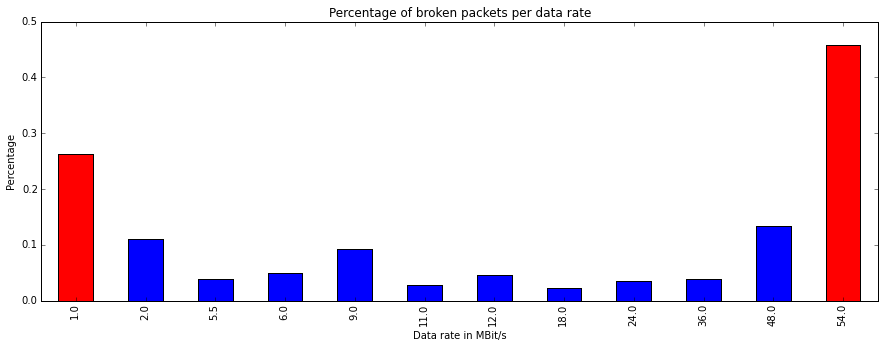

In [17]:
percentage_broken = groupedbydatarate['Broken']/total_sent['Pkts_captured']
ax = percentage_broken.plot(kind='bar', color="rbbbbbbbbbbr")
ax.set_xlabel(data_rate_label)
ax.set_ylabel("Percentage")
_ = ax.set_title("Percentage of broken packets per data rate")

The data rates with more than 20% of its packets broken are marked red here. With 54MBit/s,

<font color='red',size=9>
Note
</font>
<font color='red'>
Same here
</font>

In [18]:
percentage_broken[54.0]

0.45882162773781621

almost 46% of packets were discarded by the network adapter (including packets of wrong length: 48%).

If we compare both results now,

<font color='red',size=9>
Note
</font>
<font color='red'>
Same here
</font>

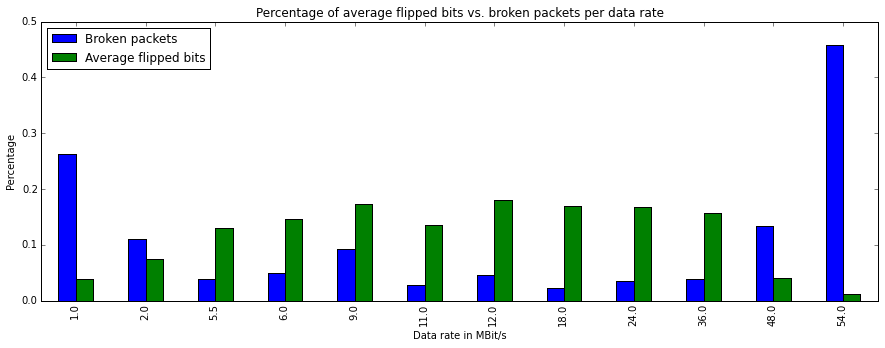

In [19]:
percentage_broken.name = "Broken packets"
percentage_flipped.name =  "Average flipped bits"
ax = pd.concat([percentage_broken, percentage_flipped], axis=1).plot(kind='bar')
ax.set_xlabel(data_rate_label)
ax.set_ylabel("Percentage")
_ = ax.set_title("Percentage of average flipped bits vs. broken packets per data rate")

the above figure shows that there is an inverse behaviour with the two discussed properties.

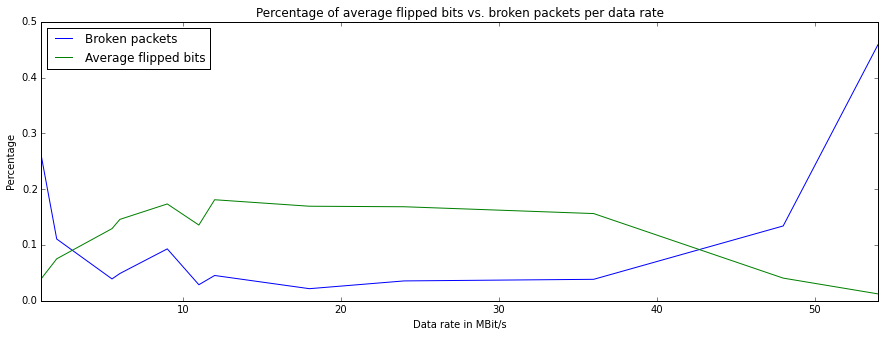

In [20]:
ax = pd.concat([percentage_broken, percentage_flipped], axis=1).plot()
ax.set_xlabel(data_rate_label)
ax.set_ylabel("Percentage")
_ = ax.set_title("Percentage of average flipped bits vs. broken packets per data rate")

Even though lower data rates like 1 or 2 MBit/s or high data rates like 48 and especially 54 MBit/s have 
* 10 to 45% failed CRCs, 
* the percentage of flipped bits per packet is low with 1% to 10%.

On the other hand, intermediate data rates from 5.5 to 36MBit/s have 
* less broken packets (between 2-10%), 
* but those show an increased number of flipped bits ranging from 12.9% to 18%.

For the algorithm this research is done for, the first group is of more interest. By having less errors per packet, but a higher failure rate of CRCs, the gain of using broken packets as useful information is higher.

### Computing gain

Under the assumption that errors do not occur at the same places within two packets, we can compute an upper bound of the gain of the proposed algorithm for the examined scenario.

As an example of best perfomance, 54Mbit/s is used. With only about 1.24% of bits flipped per broken packet, the above assumption is reasonable.

<font color='red',size=9>
Note
</font>
<font color='red'>
I liked this analysis. I would suggest to render with latex notation the equations. That will make easier to follow your analysis. I'ts easier to read pretty Latex equations than python code
</font>

In [21]:
percentage_flipped[54.0]

0.012414256356056603

Around 2.2% of the packets have a different length than the sent 10000 bits, so the percentage of packets of wrong length is __not__ neglected here.

In [22]:
percentage_wrong_length[54.0]

0.021929470082706969

At first, the data rate without using broken packets is 

<font color='red',size=9>
Note
</font>
<font color='red'>
something like:
</font>

$Rate_{CRC ok} = (1 - F_{Broken\,packets} - F_{Wrong\,length}) \cdot 54$

In [23]:
data_rate_CRC_ok = (1 - percentage_broken[54.0] - percentage_wrong_length[54.0])*54.0
data_rate_CRC_ok

28.03944071769175

With the suggested algorithm, two "useful" broken packets together with one with successful CRC are merged and contain the information of two correctly decoded packets.

As the percentage of (useful) broken packets does not exceed 66.6%, every packet - broken as well as nonbroken -  can be used and we can compute the upper bound very easily (in MBit/s):

In [24]:
upper_bound = data_rate_CRC_ok + percentage_broken[54.0]/2*54.0
upper_bound

40.427624666612786

This would result in a gain of

In [25]:
upper_bound/data_rate_CRC_ok

1.4418128048147762

approximately 44,18%. This complies with the assumption that the average gain of the PRAC algorithm is around 34%. ["PRAC: Exploiting Partial Packets without Cross-layer or Feedback Information", Angelopoulos, Chandrakasan, Médard]

The possibility of reaching this bound depends on the distribution of errors within in a packet. This distribution will be examined below.

## 3. Positions of erroneous bits
To analyse the position of bit errors a dictionary of counters is introduced. The function is passed a dataframe to create the keys corresponding to the data rates in the dataframe.

Each counter contains an array of 10000 zeros.

In [26]:
def make_counters(df):
    counter = {}
    for data_rate in df['Data_rate'].unique():
        counter[data_rate] = np.zeros(10000)
    return counter

The following function is applied to every packet and increases the counter for the respective data rate and position if an error has occurred, i.e. if a '1' is found.

In [27]:
def inc_counter(v):
    where_am_i = 0
    for e in v['Data_bin']:
        if e == '1':
            counter[v['Data_rate']][where_am_i] += 1
        where_am_i += 1

The function is applied and from the counter, another dataframe created.

CPU times: user 4min 36s, sys: 1.14 s, total: 4min 37s
Wall time: 4min 37s


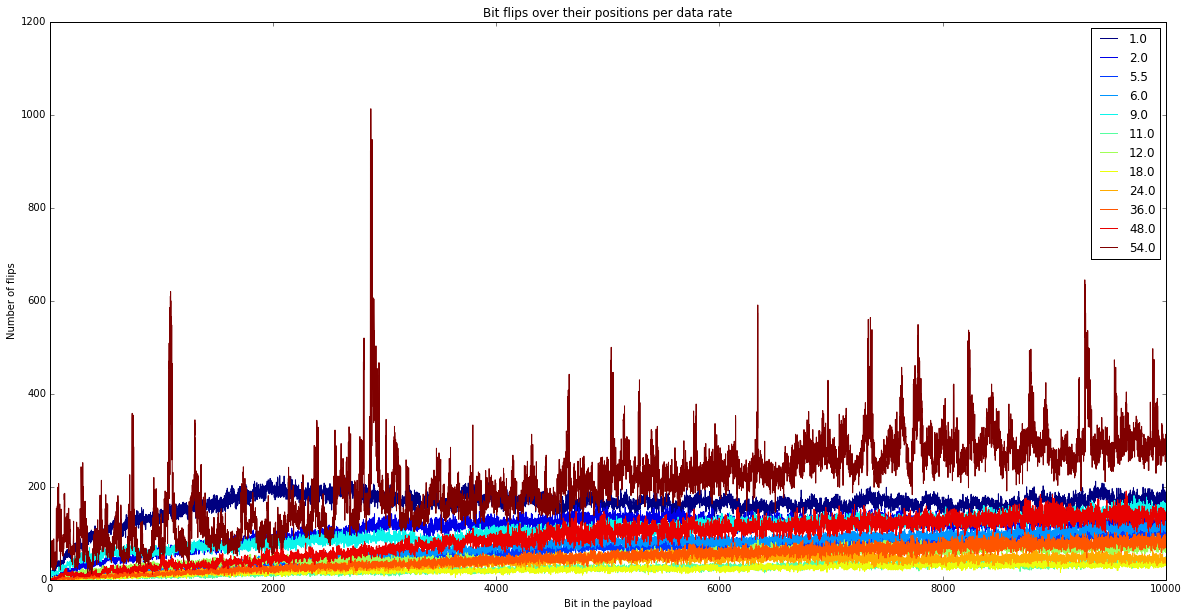

In [28]:
%%time
relevant_data = right_length[['Data_rate', 'Data_bin']]
counter = make_counters(relevant_data)

_ = relevant_data.apply(inc_counter, axis=1)

sum_flipped = pd.DataFrame(counter)
ax = sum_flipped.plot(figsize=(20, 10), colormap='jet')
ax.set_xlabel("Bit in the payload")
ax.set_ylabel("Number of flips")
_ = ax.set_title("Bit flips over their positions per data rate")

### _Digression: Evaluation of algorithm perfomance_

With the device used for this analysis, the ``` %%time ``` magic function produced the following output for the above cell:
> CPU times: user 4min 36s, sys: 1.14 s, total: 4min 37s

> Wall time: 4min 37s

This indicates that here is space for optimization for the applied function, as a for-loop consumes a lot of time in Python. This is even more significant because the next slowest cell (initialization) took only 2.14 seconds on the same machine.
### Analysis of bit error positions
The number of flipped bits is now related to the number of packets sent for each rate and displayed with logarithmic scaling for the y-axis.

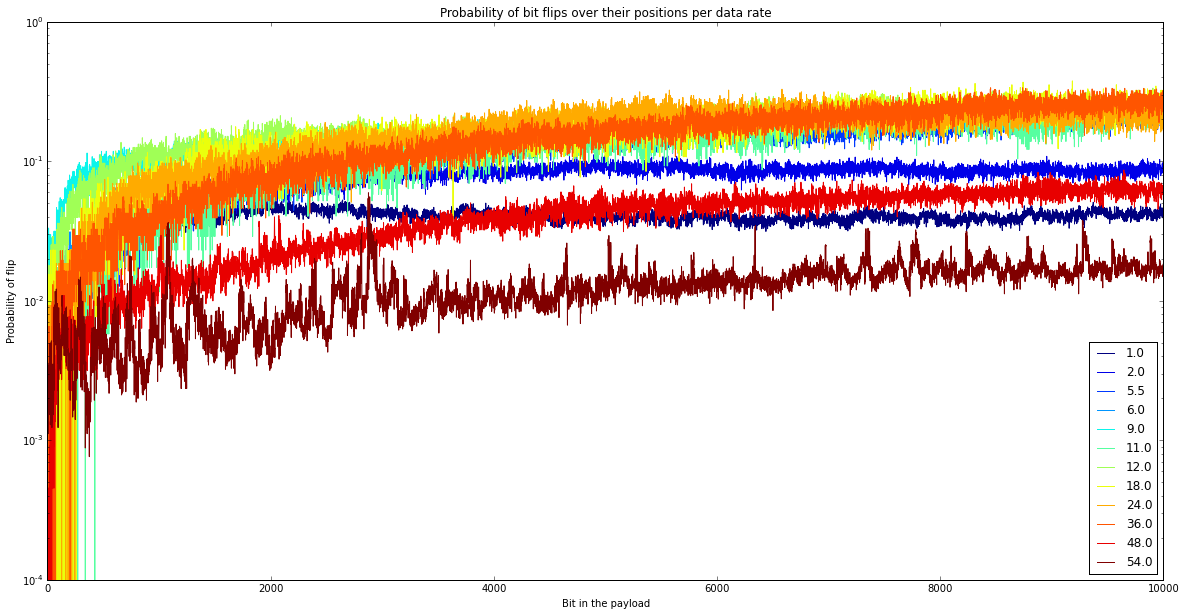

In [29]:
normalized_df = sum_flipped.T.divide(groupedbydatarate['Broken'], axis=0).T
ax = normalized_df.plot(figsize=(20,10), logy=True, colormap='jet')
ax.set_xlabel("Bit in the payload")
ax.set_ylabel("Probability of flip")
_ = ax.set_title("Probability of bit flips over their positions per data rate")

At first, a rising tendency of flipped bits from MSB to LSB in a packet can be observed. 

In [12]:
ax = normalized_df.mean(axis=1).plot(logy=True)
ax.set_xlabel("Bit in the payload")
ax.set_ylabel("Probability of flip")
_ = ax.set_title("Mean probability of bit flips over their positions")

NameError: name 'normalized_df' is not defined

<font color='red',size=9>
Note
</font>
<font color='red'>
Good observation!
</font>

This may be caused by convolutional codes that leave a trace in the following bits and increase the propability of correct decoding if the bit before has been decoded correctly. Correctly decoding the first bits of a convolutional code is more probable because there are less paths in the Trellis diagram.

But for the data rates that used 802.11b, no convolutional FEC is used while their failure is also rising. So either DSSS is also causing the rising failure rates or convolutional codes are not the reason.

Another possible reason for a rising failure rate is the fact that in IEEE 802.11b/g, [the training sequence is a preamble][1]. So if the channel properties change while the transmission of the packet is in progress, the decoding perfomance will decline.

[1]:http://www.cnrood.com/public/docs/WiFi_Physical_Layer_and_Transm_Meas.pdf "Wi-Fi: Overview of the 802.11 Physical Layer and Transmitter Measurements, Page 21"



### IEEE 802.11 standards and error positions

To simplify identification of data rates in the plots, a rolling mean was applied.

All graphs from IEEE 802.11b data rates are colored in green, those from IEEE 802.11g in blue.

<font color='red',size=9>
Note
</font>
<font color='red'>
Is this error suppose to be here? Maybe i missclicked and ran the cell
</font>

In [11]:
ax = pd.rolling_mean(normalized_df, 100).plot(logy=True, color='bbbggbgggggggggg', figsize=(20, 10))
ax.set_xlabel("Bit in the payload")
ax.set_ylabel("Probability of flip")
_ = ax.set_title("Probability of bit flips over their positions with IEEE 802.11 standards b/g differently colored")

NameError: name 'normalized_df' is not defined

On the one hand, this indicates that the IEEE 802.11 standard does not determine the shape of the curve as they are neither found in a common area nor share a common gradient.

<font color='red',size=9>
Note
</font>
<font color='red'>
I like a lot these graphs. However, it would be nice a further description of what the function "rolling mean" is doing and what conclusions you derive from these plots.
</font>

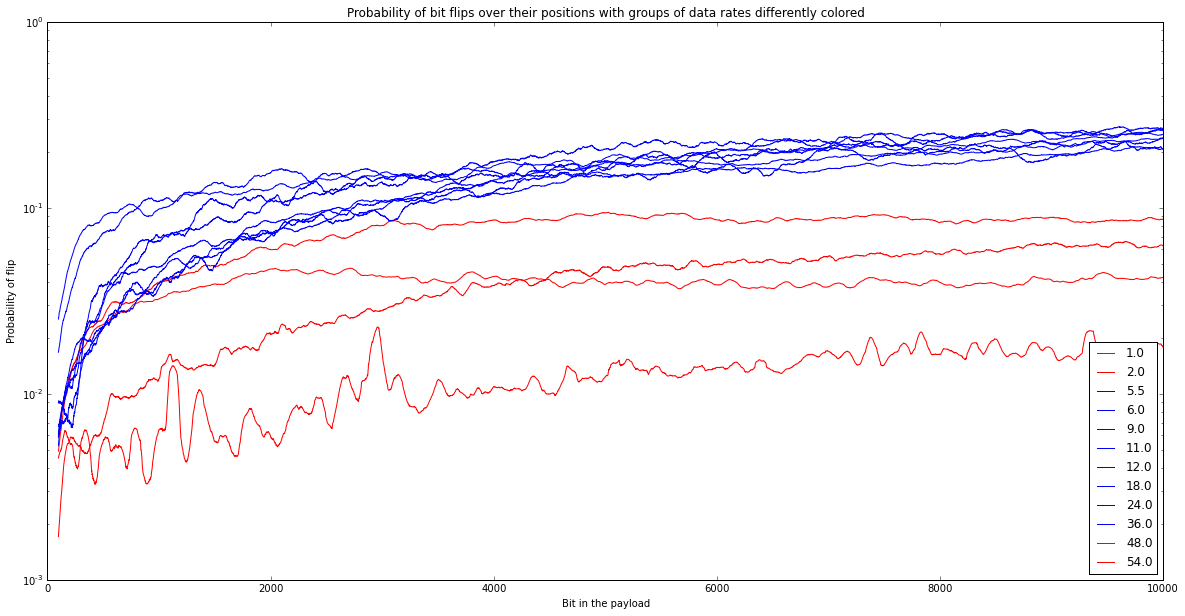

In [32]:
ax = pd.rolling_mean(normalized_df, 100).plot(logy=True, color='rrbbbbbbbbrr', figsize=(20, 10))
ax.set_xlabel("Bit in the payload")
ax.set_ylabel("Probability of flip")
_ = ax.set_title("Probability of bit flips over their positions with groups of data rates differently colored")

Splitting the dataset in "extreme" and "intermediate" data rates, on the other hand, indicates correlation.

## Summary
The analysis shows that the data rates used for creating the test data heavily influences 
* how many packets are broken at the receiver, 
* how many bits flips they show and 
* where those occur.

Unlike one could expect, this does not depend if the IEEE 802.11 standards b or g are used, but if the data rates come from an intermediate range or not.

Below, you find a qualitative analysis of properties of thoses ranges.

| Property                 | "Intermediate range"  | "Extreme range" |
| ---------------------    | --------------------- | --------------  |
| Data rates /MBit/s       | 5.5, 6, 9, 12, 18, 36 | 1, 2, 48, 54    |
| Number of broken packets | Low                   | High            |
| Number of flipped bits   | High                  | Low             |
| Assumed probability density function of position of flipped bits | Linearly rising to the end | Rising, later stagnating |

### Outlook
Clearly, this is a brief overview over statistics of packet errors using IEEE 802.11 standards.

More work could be done by:
* Exploring the reason of correlation between data rates and packet errors
* Varying the creation of test data, e.g. other SNR scenarios
* Using other air interfaces, e.g. mobile data or Bluetooth